### <h1 style="font-size:45px; background: black; background-image: url(https://images.ctfassets.net/cnu0m8re1exe/5BIngirakRnX3gIKHE3c2M/63905ab53aa5b2b8cf3f1fa5b4013f94/bhbinary_xmm_960.jpg?w=650&h=433&fit=fill); color: white; background-size:contain; background-repeat: no-repeat; background-position: right; height: 400px; padding: 130px 10px; font-family: Georgia, serif">BH-NS LISA Detection Rate using COMPAS Simulation</h1>

### Imports

In [17]:
from __future__ import division 
import h5py as h5
import numpy as np
import scipy.stats as stats
from scipy.integrate import odeint, quad
from scipy.special import jv

import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors

from astropy.visualization import quantity_support
import astropy.units as u
import astropy.constants as c

# functions from Robson et al. 2019
import lisa_tools.PhenomA as pa
import lisa_tools.LISA as li
import lisa_tools.WaveformTools as wt

# muAres sensitivity curve (from Valeriya Korol)
import strain_sens_muHz as muAres

# metallicity mass conversion
import transform_rates.coencodeVarious as CV
import transform_rates.FormationChannel as FC
import transform_rates.totalMassEvolvedPerZ as TMEPZ

import breivik as bre

import time

%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='serif')
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['hatch.color'] = "white"
fs = 24

ModuleNotFoundError: No module named 'lisa_tools'

### COMPAS File Functions

In [232]:
print(min(get_COMPAS_variable(fdata, ("eccentricityDCOFormation", "doubleCompactObjects"))))

0.000719655


In [174]:
def get_COMPAS_variable(h5file, param):
    """ Return a variable from the COMPAS output data
        h5file --> [h5]    variable containing an h5 File
        param  --> [tuple] name of variable and hdf5 keyname """
    xparam, fxparam = param
    return h5file[fxparam][xparam][...].squeeze()

In [175]:
def mask_COMPAS_data(h5file, DCO_type, flags):
    """ mask COMPAS data based on type and flags
        h5file    --> [h5]         variable containing an h5 File
        DCO_type  --> [str]        'ALL', 'BBH', 'BHNS', or 'BNS'
        bool_mask --> [bool tuple] flags: (mask binaries not merging in a Hubble time, 
                                           mask binaries with RLOF secondary after CEE,
                                           mask Pessimistic CE binaries) """
    hubble, RLOF, pessimistic = flags
    fDCO = h5file['doubleCompactObjects']
    
    # get the total number of binaries
    BINARIES = len(fDCO['stellarType1'][...].squeeze())
    
    # store the stellar type of both stars
    type1, type2 = fDCO['stellarType1'][...].squeeze(), fDCO['stellarType2'][...].squeeze()
    
    # create a mask where BH=14 and NS=13
    if DCO_type == "ALL":
        type_mask = np.repeat(True, BINARIES)
    elif DCO_type == "BBH":
        type_mask = np.logical_and(type1 == 14, type2 == 14)
    elif DCO_type == "BNS":
        type_mask = np.logical_and(type1 == 13, type2 == 13)
    elif DCO_type == "BHNS":
        type_mask = np.logical_or(np.logical_and(type1 == 14, type2 == 13),
                                  np.logical_and(type1 == 13, type2 == 14))
    else:
        print("Error: Invalid DCO_type")
        return
        
    if hubble:
        hubble_mask = fDCO['mergesInHubbleTimeFlag'][...].squeeze()
    else:
        hubble_mask = np.repeat(True, BINARIES)
        
    if RLOF:
        rlof_mask = np.logical_not(fDCO['RLOFSecondaryAfterCEE'][...].squeeze())
    else:
        rlof_mask = np.repeat(True, BINARIES)
        
    if pessimistic:
        pessimistic_mask = np.logical_not(fDCO['optimisticCEFlag'][...].squeeze())
    else:
        pessimistic_mask = np.repeat(True, BINARIES)
    
    # combine all masks
    mask = type_mask * hubble_mask * rlof_mask * pessimistic_mask
        
    return mask

In [231]:
folder_path = './'
file_name = 'COMPASOutput_lowz.h5'

file_path = folder_path + file_name

fdata = h5.File(file_path, 'r+')

## Detection Rate Calculation
### Get data and compute necessary variables

In [177]:
# retrieve variables
m1_all = get_COMPAS_variable(fdata, ['M1', 'doubleCompactObjects'])
m2_all = get_COMPAS_variable(fdata, ['M2', 'doubleCompactObjects'])
a_all = get_COMPAS_variable(fdata, ['separationDCOFormation', 'doubleCompactObjects'])
e_all = get_COMPAS_variable(fdata, ['eccentricityDCOFormation', 'doubleCompactObjects'])
tform_all = get_COMPAS_variable(fdata, ['tform', 'doubleCompactObjects'])
tc_all = get_COMPAS_variable(fdata, ['tc', 'doubleCompactObjects'])
weightsDCO_all = get_COMPAS_variable(fdata, ['weight', 'doubleCompactObjects'])

In [178]:
# mask the data to get only BHNSs that merge in a Hubble time, have RLOF and are pessimistic
maskBHNSinaHubble = mask_COMPAS_data(fdata, 'BHNS', (True, True, True))

# get the chirp mass of these systems
m1 = m1_all[maskBHNSinaHubble] * u.M_sun
m2 = m2_all[maskBHNSinaHubble] * u.M_sun
weightsDCO = weightsDCO_all[maskBHNSinaHubble]
a = a_all[maskBHNSinaHubble] * u.au
e = e_all[maskBHNSinaHubble]
tform = tform_all[maskBHNSinaHubble] * u.Myr

In [179]:
# constants
MW_AGE = 1e10 * u.yr
SNR_CUTOFF = 7
TOTAL_BINARIES = len(cm)
lisa = li.LISA()

Calculate the coalesence time using equation 5.14 from Peters (1964):
$$ T\left(a_{0}, e_{0}\right) = \frac{12}{19} \frac{c_{0}^{4}}{\beta} \int_{0}^{e_{0}} \frac{d e e^{29 / 19}\left[1+(121 / 304) e^{2}\right]^{1181 / 2299}}{\left(1-e^{2}\right)^{3 / 2}} $$
where
$$ \beta = \frac{64}{5} \frac{G^3 m_1 m_2 (m_1 + m_2)}{c^5} $$
$$ c_0 = a_0 \frac{(1 - e_0)^2}{e_0^{12/19} (1 + \frac{121}{304} e_0^2)^{870/2299}} $$

In [180]:
def coalescence_time(a0, e0, m1, m2):
    """ Calculate the coalescence of a binary with Peter (1964) Eq. 5.14
        a0 --> [array_like] starting semi-major axis
        e0 --> [array_like] starting eccentricity
        m1 --> [array_like] primary mass
        m2 --> [array_like] secondary mass """
    c0 = a0 * (1.0 - e0**2)*np.power(e0,-12.0/19.0)*np.power(1+(121.0*e0**2/304.0), -870.0/2299.0)
    beta = (64 / 5) * (c.G**3 * m1 * m2 * (m1 + m2)) / c.c**5
    
    def intfunc(e):
        return np.power(e, 29/19) * np.power(1 + (121/304)*e**2, 1181/2299) / np.power(1 - e**2, 3/2)
    
    t_inspr = [((12 / 19) * c0[i]**4 / beta[i] * quad(intfunc, 0, e0[i])[0]).to(u.Myr).value
               for i in range(len(e0))]
    return t_inspr if len(t_inspr) > 1 else t_inspr[0]

tc = coalescence_time(a, e, m1, m2) * u.Myr

$$ \mathcal{M}_c = \frac{(m_1 m_2)^{3/5}}{(m_1 + m_2)^{1/5}} $$

In [181]:
def chirp_mass(m1, m2):
    """ Calculate the chirp mass of a binary system
        m1 --> [array_like] primary mass
        m2 --> [array_like] secondary mass """
    return np.divide(np.power(np.multiply(m1, m2), 3/5), np.power(np.add(m1, m2), 1/5))
cm = chirp_mass(m1, m2)

Calculate the gravitational wave frequency (twice the orbital frequency)
$$ f_{\rm GW} (a, m_1, m_2) = \frac{1}{\pi} \sqrt{\frac{G (m_1 + m_2)}{a^3}} $$

In [182]:
def gw_frequency(a, m1, m2):
    """ Convert separation of a binary to frequency.
        a  --> [array_like] separation of binary
        m1 --> [array_like] mass of primary star
        m2 --> [array_like] mass of secondary star """
    freq = (1 / np.pi) * np.sqrt(np.divide(c.G * np.add(m1, m2), np.power(a, 3)))
    return freq.to(1 / u.s)

# convert the separation to frequency
freq = gw_frequency(a, m1, m2)

## 2. Plot Sensitivity Curve with one simulation
### Strain and SNR Functions

First, we are going to need two functions $F(e)$ and $g(n, e)$ in the following calculations each of which is defined as follows in Peters (1963).
$$ F(e) = \frac{1+(73 / 24) e^{2}+(37 / 96) e^{4}}{\left(1-e^{2}\right)^{7 / 2}} $$

In [183]:
def F(e):
    """ Calculate F(e) from Peters (1963) Eq.17
        e --> [array_like] eccentricity """
    return np.divide(1 + 73/24 * np.square(e) + 37/96 * np.power(e, 4), np.power(1 - np.square(e), 7/2))

Noting that $J_{n}(ne)$ is a Bessel function of the first kind
$$ \begin{aligned}
g(n, e)=& \frac{n^{4}}{32}\left\{\left[J_{n-2}(n e)-2 e J_{n-1}(n e)+\frac{2}{n} J_{n}(n e)+2 e J_{n+1}(n e)-J_{n+2}(n e)\right]^{2}\right.\\
&\left.+\left(1-e^{2}\right)\left[J_{n-2}(n e)-2 J_{n}(n e)+J_{n+2}(n e)\right]^{2}+\frac{4}{3 n^{2}}\left[J_{n}(n e)\right]^{2}\right\}
\end{aligned} $$

In [184]:
def g(n, e):
    """ Calculate g(n, e) from Peters (1963) Eq.20
        n  --> [int]        harmonic number
        e  --> [array_like] eccentricity"""
    ne = n * e
    return (n**4 / 32.0) * (
        np.square(jv(n - 2, ne) - 2 * e * jv(n - 1, ne) + (2.0 / n) * jv(n, ne) + 2 * e * jv(n + 1, ne) - jv(n + 2, ne)) +
        (1 - np.square(e)) * np.square(jv(n - 2, ne) - 2 * jv(n, ne) + jv(n + 2, ne)) +
        (4 / (3.0 * n**2)) * np.square(jv(n, ne))
    )

The characteristic strain is defined as the following (e.g, Barack & Cutler, 2004)
$$ h_{c,n}^2 = \frac{1}{(\pi D)^2} \left( \frac{2 G}{c^3} \frac{\dot{E}_n}{\dot{f_n}} \right) $$
where $\dot{E}_n$ is given in Peters (1963) as
$$ \frac{32}{5} \frac{G^{7 / 3}}{c^{5}}\left(2 \pi f_{\mathrm{orb}} \mathcal{M}_{c}\right)^{10 / 3} g(n, e) $$
and $ \dot{f}_n = n \dot{f}_{\rm orb} $ which is equal to
$$ 
\begin{align}
    \frac{\mathrm{d} f_{\rm orb}}{\mathrm{d} t} &= \frac{\mathrm{d} f_{\rm orb}}{\mathrm{d} a} \frac{\mathrm{d} a}{\mathrm{d} t} \\
    &= - \frac{3}{4 \pi} \frac{\sqrt{ G (m_1 + m_2) }}{a^{5/2}} \cdot - \frac{64}{5} \frac{G^3 m_1 m_2 (m_1 + m_2)}{c^5} F(e) \\
    &= - \frac{48}{5 \pi} \frac{(G \mathcal{M}_c)^{5/3}}{c^5} (2 \pi f_{\rm orb})^{11/3} F(e)
\end{align}
$$
combining these expressions gives a final equation for the characteristic strain
$$ \boxed{ h_{c, n}^{2}=\frac{2}{3 \pi^{4 / 3}} \frac{\left(G \mathcal{M}_{c}\right)^{5 / 3}}{c^{3} D_{L}^{2}} \frac{1}{f_{n}^{1 / 3}}\left(\frac{2}{n}\right)^{2 / 3} \frac{g(n, e)}{F(e)} } $$

In [185]:
HC2_CONSTS = np.divide(2 * np.power(c.G, 5/3), 3 * np.power(np.pi, 4/3) * np.power(c.c, 3))
def characteristic_strain(Mc, D, f, e, n):
    """ Find the nth harmonic *characteristic* strain caused by a binary
        Mc --> [array_like] Chirp Mass
        D  --> [array_like] Distance
        f  --> [array_like] Gravitational Wave Frequency (2 * orbital)
        n  --> [int]        Harmonic Number """
    hcn2 = HC2_CONSTS * np.power(Mc, 5/3.) / np.power(D, 2) / np.power(f / 2. * n, 1/3) * \
           np.power(2 / n, 2/3) * (g(n, e) / F(e))
    return np.sqrt(hcn2).decompose()

def total_characteristic_strain(Mc, D, f, e, nf=100):
    """ Find the total *characteristic* strain caused by a binary up to the nfth harmonth
        Mc --> [array_like] Chirp Mass
        D  --> [array_like] Distance
        f  --> [array_like] Gravitational Wave Frequency (2 * orbital)
        nf --> [int]        Final harmonic number of sum """
    return np.sum([characteristic_strain(Mc, D, f, e, n) for n in range(1, nf)], axis=0)

def total_ASD(Mc, D, f, e, Tobs=4 * u.yr, nf=100):
    hnpre = np.sqrt(2**(25/3) / 5) * np.multiply(np.divide(np.power(c.G * Mc, 5/3), D * c.c**4), 
                                                         np.power((f / 2) * np.pi, 2/3))
    hnsum = np.sqrt(np.sum([g(n, e) / (n**2) for n in range(1, nf)], axis=0))
    asd = hnpre * hnsum * np.sqrt(Tobs)
    return asd.to(u.Hz**(-1/2))

Finally, the signal-to-noise ratio. This is defined in Finn & Thorne (2000) as
$$ \left(\frac{S}{N}\right)^2 = \int\left[\frac{h_{c, m}\left(f_{m}\right)}{h_{\mathrm{n}}\left(f_{m}\right)}\right]^{2} d \ln f_{m}. $$
Yet, since LISA BHNS binaries are stationary in frequency space, we can write this without the integral
$$ \left(\frac{S}{N}\right)^{2} \approx \sum_{n=1}^{\infty}\left[\frac{h_{n}\left(f_{n}\right)}{h_{f}\left(f_{n}\right)}\right]^{2} f_{n} T_{\mathrm{obs}}, $$
and this can be further simplifed by converting to using the amplitude spectral density of the noise of LISA
$$ \left(\frac{S}{N}\right)^{2} \approx T_{\mathrm{obs}} \sum_{n=1}^{\infty} \frac{h_n^2(f_n)}{S_n(f_n)}. $$
We know from Finn & Thorne (2000) that the strain can be written in terms of the characteristic strain as
$$ h_n^2 = \left(\frac{\dot{f_n}}{2 f_n^2} \right) h_{c, n}^2, $$
which gives the equation for the strain (using the equation for characteristic strain above) as
$$ h_n^2 = \frac{2^{25/3}}{5} \frac{\left(G \mathcal{M}_{c}\right)^{10/3}}{c^{8}} \frac{\left(\pi f_{\mathrm{orb}}\right)^{4 / 3}}{D^2} \frac{g(n, e)}{n^2}, $$
therefore we can write a final expression for the signal-to-noise ratio as:
$$ \boxed{ \left(\frac{S}{N}\right)^2 \approx \frac{2^{25/3}}{5} \frac{\left(G \mathcal{M}_c \right)^{10/3}}{c^8} \frac{(\pi f_{\rm orb})^{4/3}}{D^2} \cdot T_{\mathrm{obs}} \cdot \sum_{n=1}^{\infty} \frac{g(n, e)}{n^2} \frac{1}{S_n(f_n)} } $$

In [186]:
def calc_snr(Mc, D, f, Sn, e, T=4*u.yr, nf=100):
    """ Find the signal-to-noise ratio for a LISA binary
        Mc --> [array_like] Chirp Mass
        D  --> [array_like] Distance
        f  --> [array_like] Frequency
        Sn --> [function]   Sensitivity curve to check against
        e  --> [array_like] Eccentricity
        T  --> [float]      Observing Time (Default LISA Mission Length)
        nf --> [int]        Final value of n """
    
    # calculate prefactor to the sum
    prefactor = np.sqrt(2**(25/3) * T / 5) * np.multiply(np.divide(np.power(c.G * Mc, 5/3), D * c.c**4), 
                                                         np.power((f / 2) * np.pi, 2/3))
    
    # sum over the contributions from different harmonics
    sum_over_harmonics = np.sum([g(n, e) / (n**2 * Sn((f.to(u.Hz).value / 2 * n))) for n in range(1, nf)], axis=0)
    
    # return the product
    return np.multiply(prefactor.to(u.s**(1/2)).value, np.sqrt(sum_over_harmonics))

### Orbit Evolution Functions
These functions evolve the eccentricity and allow us to convert this to a final semi-major axis.

The rate of change of eccentricity (Peters, 1964, Eq. 5.13) and be integrated to find the final eccentricity
$$ \frac{\mathrm{d}e}{\mathrm{d}t} = -\frac{19}{12} \frac{\beta}{c_0^4} \frac{e^{-29/19} (1 - e^2)^{3/2}}{\left(1 + \frac{121}{304} e^2\right)^{1181/2299}}, $$
where $\beta$ and $c_0$ are defined above. This final eccentricity and then be converted to a final semi-major axis using Peters (1964) Eq. 5.11
$$ a(e) = \frac{c_0 e^{12/19}}{(1 - e^2)} \left[1 + \frac{121}{304} e^2 \right]^{870/2299} $$

In [187]:
def dedt(e, beta, c0):
    """ Rate of change of eccentricity from Peters (1964) Eq. 5.13
        e    --> [array_like] eccentricity
        beta --> [array_like] beta constant from Peters (1964), see Eq. 5.9
        c0   --> [array_like] c0 constant from Peters (1964), see Eq. 5.11 """
    return - (19 / 12) * (beta / np.power(c0, 4)) * (np.power(e, -29/19) * np.power(1 - np.square(e), 3/2)) \
            / np.power(1 + (121/304) * np.square(e), 1181.0/2299.0)

def evolve_eccentricity(e0, a0, m1, m2, t, nsteps=10000):
    """ Evolve the eccentricity of a binary by numerically integrating
        e0     --> [array_like] starting eccentricity
        a0     --> [array_like] starting semi major axis
        m1     --> [array_like] primary star mass
        m2     --> [array_like] secondary star mass
        t      --> [array_like] evolution time
        nsteps --> [int]        number of integration steps to take """
    # calculate constants
    c0 = (a0 * (1.0 - np.square(e0)) * np.power(e0,-12.0/19.0) * \
          np.power(1 + (121.0/304.0) * np.square(e0), -870.0/2299.0)).to(u.m).value
    beta = (64/5 * c.G**3 * m1 * m2 * (m1 + m2) / c.c**5).to(u.m**4 / u.s).value

    # initialise values
    e = np.array(e0)

    # find time step
    dt = np.divide(t.to(u.s).value, nsteps)

    # perform Euler's method
    for i in range(nsteps):
        e = e + dedt(e, beta, c0) * dt
        a = e_to_a(e, c0)
        c0 = f(e, a)
    return e, c0 * u.m

def e_to_a(e, c0):
    """ Convert eccentricity to semi major axis using Peters (1964) Eq. 5.11
        e  --> [array_like] eccentricity
        c0 --> [array_like] c0 constant from Peters (1964), see Eq. 5.11 """
    a = c0 / (1.0 - np.square(e)) * np.power(e, 12.0/19.0) * np.power(1+(121.0*np.square(e)/304.0), 870.0/2299.0)
    return a.to(u.AU)

In [201]:
def myhn(mc, D, forb, e, n):
    CONST = 2**(25/3.0) / 5.0 * c.G**(10/3.0) / c.c**8
    factor = mc**(10/3.0) * (np.pi * forb)**(4/3.0) / D**2
    nfac = g(n, e) / n**2
    
    return np.sqrt(CONST * factor * nfac)

x = np.log10(myhn(masses, distances, freq_currents / 2, e_currents, 2).decompose()).astype(int)
y = np.log10(bre.h_ecc_stationary(mass1.value, mass2.value, (2 / freq_currents).value, distances.to(u.kpc).value, e_currents, 2)).astype(int)

z = y - x
print(z[z>0])

[]


### Milky Way Simulation Functions
These functions use the density distributions from McMillan to sample a mock Milky Way assuming there is only a disk.

In [26]:
def random_mw_radius_or_height(count, scale_length):
    """ 
        Create a random sample of radii or heights using McMillan (2011)
        and the inverse CDF method.
        
        Args:
            count        --> [int]             number of lengths
            scale_length --> [array_like, kpc] scale length
        
        Returns:
            r (or z)     --> [array_like, kpc] random radii or heights
    """
    u = np.random.rand(count)
    r = - scale_length * np.log(1 - u)
    return r[0] if count == 1 else r

def simulate_milky_way(count=1, components=[
                                    {"type": "disk", "scale_height": 0.3 * u.kpc, "scale_radius": 2.6 * u.kpc}
                                ]):
    """
        Create a random sample of positions in Milky Way and return distances to these points
        Uses McMillan (2011) for Milky Models
        
        Args:
            count      --> [int]              number of positions to simulate
            components --> [array_like, dict] array of Milky Way components
            
            Each component is a dictionary with information about what type of component it is
            and the scale of heights and radii.
            Example: {"type": "disk", "scale_height": 0.3 * u.kpc, "scale_radius": 2.6 * u.kpc}
            
            Allowed types are 'disk', 'bulge', and 'halo'.
            
        Returns:
            distances  --> [array_like, kpc]  array of distances to each random position
    """
    EARTH_TO_MW_CENTRE = 8.2 * u.kpc
    
    # single component Milky Way model
    if len(components) == 1 and components[0]["type"] == "disk":
        
        # randomise radii and heights
        radii = random_mw_radius_or_height(count, 2.6 * u.kpc)
        heights = random_mw_radius_or_height(count, 0.3 * u.kpc) * np.random.choice([-1, 1], count)

        # sample angles uniformly on a circle
        angles = 2 * np.pi * np.random.rand(count)

        # calculate the distance to each coordinate
        distances = np.sqrt(np.square(heights) + np.square(radii) + np.square(EARTH_TO_MW_CENTRE) \
                            - 2 * radii * EARTH_TO_MW_CENTRE * np.cos(angles))
        return distances[0] if count == 1 else distances
    else:
        # TODO: implement multi-component galaxies
        raise NotImplementedError

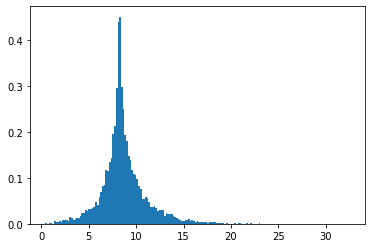

In [37]:
plt.hist(simulate_milky_way(10000).value, bins='auto', density=True)
plt.show()

In [190]:
def random_mw_radius_or_height(count=1, Rd=2.6 * u.kpc):
    """ Create a random sample of radii or heights using the inverse CDF method.
        Default Rd = 2.6kpc for radius, 0.3kpc for height
        count --> [int]   number of distances
        Rd    --> [float] disk scale length """
    u = np.random.rand(count)
    r = - Rd * np.log(1 - u)
    return r if count == 1 else r[0]

In [191]:
def create_random_distances(count=1):
    EARTH_TO_MW_CENTRE = 8 * u.kpc
    
    # sample random radii from McMillan distribution
    radii = random_mw_radius_or_height(count)
    
    # sample random heights from McMillan and randomise above or below plane
    heights = random_mw_radius_or_height(count, 0.3 * u.kpc) * np.random.choice([-1, 1], count)
    
    # sample angles uniformly on a circle
    angles = 2 * np.pi * np.random.rand(count)
    
    # calculate the distance to each coordinate
    distances = np.sqrt(np.square(heights) + np.square(radii) + np.square(EARTH_TO_MW_CENTRE) \
                        - 2 * radii * EARTH_TO_MW_CENTRE * np.cos(angles))
    return distances

In [49]:
def random_inspiral_times(count, evolution_times, age=10*u.Gyr):
    """
        Create a random sample of insprial times, assuming constant star formation
        
        Args:
            count -->
            evolution_times -->
    """
    
    if count == 1 and not isinstance(evolution_times.value, float) \
        or len(evolution_times) != count:
            print("Error: Count must match the number of evolution times provided.")
            raise IndexError
    
    # randomise birth times uniformly
    formation_times = np.random.rand(count) * age

    # double compact object is formed t_form after t_birth
    DCO_times = formation_times + evolution_times

    # binary will inspiral for the rest of the age of the Milky Way
    inspiral_times = age - DCO_times
    
    return insprial_times

In [50]:
print(random_inspiral_times(len(tform), tform))

NameError: name 'tform' is not defined

### One simulation of the Milky Way and LISA

In [208]:
# create random list of start times
starts = np.random.rand(TOTAL_BINARIES) * MW_AGE

# double compact object is formed at the start time + formation time
dco_starts = starts + tform

# binary will evolve for the rest of the age of the milky way
evolution_times = MW_AGE - dco_starts

# check which binaries will have already merged
still_merging = evolution_times < tc

# mask the variables to remove binaries that have already merged
evolution_times = evolution_times[still_merging]
weights = weightsDCO[still_merging]
masses = cm[still_merging]
times = tform[still_merging]
births = dco_starts[still_merging]
mass1, mass2 = m1[still_merging], m2[still_merging]
a_init = a[still_merging]
e_init = e[still_merging]
tco = tc[still_merging]

TOTAL_REMAINING = len(a_init)

# find current eccentricity and convert this to separation and frequency
e_currents, c0 = evolve_eccentricity(e_init, a_init, mass1, mass2, evolution_times, 100)
a_currents = e_to_a(e_currents, c0)
freq_currents = gw_frequency(a_currents, mass1, mass2)

# give each binary a random position and find its distance from the Earth
distances = create_random_distances(TOTAL_REMAINING)

# calculate the SNR for different gravitational wave detectors
snr = calc_snr(masses, distances, freq_currents, lisa.Sn, e_currents, 4 * u.yr)
long_snr = calc_snr(masses, distances, freq_currents, lisa.Sn, e_currents, 10 * u.yr)
muAres_snr = calc_snr(masses, distances, freq_currents, muAres.Sn_ares_full, e_currents, 10 * u.yr)
cstrain = total_characteristic_strain(masses, distances, freq_currents, e_currents)

# print out how many detection and their SNRs
print(len(snr[snr > 7]), len(long_snr[long_snr > 7]), len(muAres_snr[muAres_snr > 7]))
print(snr[snr > 7], long_snr[long_snr > 7], muAres_snr[muAres_snr > 7])

0 0 1
[] [] [7.98455627]


In [295]:
asd = total_ASD(masses, distances, freq_currents, e_currents)

In [221]:
def plot_sensitivity_with_binaries(Sn, yvals, snr, frequency, label, e=None, asd=False,
                                   filename=None, hide_binaries=False, alt_sn=None):
    """ Plot a gravitational wave sensitivty curve with simulated binaries overlaid
        Sn            --> [function] sensitivty curve of detector
        yvals         --> [array_like] either characteristic strain or ASD of binaries
        snr           --> [array_like] SNR of binaries
        frequency     --> [array_like] GW frequency of binaries
        label         --> [str]        Colourbar label
        e             --> [array_like] Eccentricity (if present, colour by e instead of snr)
        asd           --> [bool]       Plot ASD instead of characteristic strain
        filename      --> [str]        Name of file (if present, save plot in file)
        hide_binaries --> [bool]       Whether to show the undetectable binaries
        alt_sn        --> [function]   An alternative sensitivity curve """
    
    # remove the *really* undetectable things
    mask = snr > 1e-4
    yvals, snr, frequency = yvals[mask], snr[mask], frequency[mask]
    if e is not None:
        e = e[mask]
    
    # define detectable binaries as above a certain SNR cutoff
    detectable = snr > SNR_CUTOFF
    
    # work out the minimum frequency power of 10
    if hide_binaries and len(snr[detectable]) > 0:
        minfpow = int(np.floor(np.log10(frequency[detectable].min().value)))
    else:
        minfpow = int(np.floor(np.log10(frequency.min().value)))
    
    # define the range of frequencies to plot
    frange = np.logspace(minfpow, -2, 1000)
        
    print(snr)
    heights = yvals / np.sqrt(frequency * Sn(frequency.value))
    print(heights)
    print(heights / snr)

    # create a new figure
    fig, ax = plt.subplots(1, figsize=(12, 9))
    plt.tight_layout()

    # set and size axes labels
    ax.set_xlabel(r'Frequency [Hz]', fontsize=1.5*fs, labelpad=10)
    
    if asd:
        ax.set_ylabel(r'ASD $[\rm Hz^{-1/2}]$', fontsize=1.5*fs, labelpad=10)
    else:
        ax.set_ylabel(r'Characteristic Strain', fontsize=1.5*fs, labelpad=10)
    ax.tick_params(axis='both', which='major', labelsize=1.5*fs)

    ax.set_xlim(np.power(10.0, minfpow), 1e-2)

    cmap = 'plasma_r'
    color = matplotlib.cm.get_cmap(cmap)(1.0)
    
    sensitivity_y = np.sqrt(Sn(frange)) if asd else np.sqrt(frange * Sn(frange))
    
    ax.loglog(frange, sensitivity_y, color=color)
    ax.fill_between(frange, sensitivity_y, alpha=0.2, color=color)
    
    if alt_sn:
        alt_sensitivity_y = np.sqrt(alt_sn(frange)) if asd else np.sqrt(frange * alt_sn(frange))
        ax.loglog(frange, alt_sensitivity_y, color=color)
        ax.fill_between(frange, alt_sensitivity_y, alpha=0.2, color=color)
    
    if e is not None:
        boundaries = np.linspace(0, 1, 11)
        norm = matplotlib.colors.BoundaryNorm(boundaries, plt.cm.plasma.N)
        cmap = 'plasma'
    else:
        boundaries = np.logspace(-4, 2, 13)
        norm = matplotlib.colors.BoundaryNorm(boundaries, plt.cm.plasma_r.N)
    
    colourvar = snr if e is None else e
    if hide_binaries:        
        p = ax.scatter(frequency[detectable], yvals[detectable], s=weights*1000, c=colourvar[detectable], cmap=cmap, norm=norm, label="Detectable Binaries")
    else:
        p = ax.scatter(frequency.value, yvals,
                       s=weights*100, c=colourvar, cmap=cmap, norm=norm, label="Undetectable Binaries")
        ax.scatter(frequency[detectable], yvals[detectable], s=150, marker="*", c=colourvar[detectable], cmap=cmap, norm=norm, label="Detectable Binaries")
        legend = plt.legend(loc='best', fontsize=fs)
        legend.legendHandles[0].set_sizes([150])
        legend.legendHandles[0].set_facecolor(matplotlib.cm.get_cmap('plasma_r')(0.2))
        legend.legendHandles[1].set_sizes([250])
        legend.legendHandles[1].set_facecolor(matplotlib.cm.get_cmap('plasma_r')(1.0))
    
    if e is None:
        def fmt(x, pos):
            a, b = '{:0e}'.format(x).split('e')
            b = int(b)
            return r'$10^{{{}}}$'.format(b)
        cbar = plt.colorbar(p, ticks=boundaries[::2], format=matplotlib.ticker.FuncFormatter(fmt))
    else:
        cbar = plt.colorbar(p, ticks=boundaries[::2])
        yval = norm(SNR_CUTOFF) / norm(1e2)
        cbar.ax.plot([-0.1, 1.1], [yval, yval], linewidth=3, color='white')
    cbar.set_label(label=label, fontsize=1.5*fs, labelpad=15)
    cbar.ax.tick_params(labelsize=fs)

    if filename:
        fig.savefig(filename.replace(".png", ".pdf"), format="pdf", bbox_inches='tight')
        fig.savefig(filename, bbox_inches='tight')

    plt.show()

[0.0004672  0.01058906 0.00415189 ... 0.00119418 0.00262004 0.00150492]
[ 36.45480028 227.13268072 133.9069342  ...  62.97888155   8.3926395
  37.93671667] s(1/2)
[78027.60272569 21449.75726254 32252.03314979 ... 52738.16838986
  3203.24882881 25208.44489134] s(1/2)


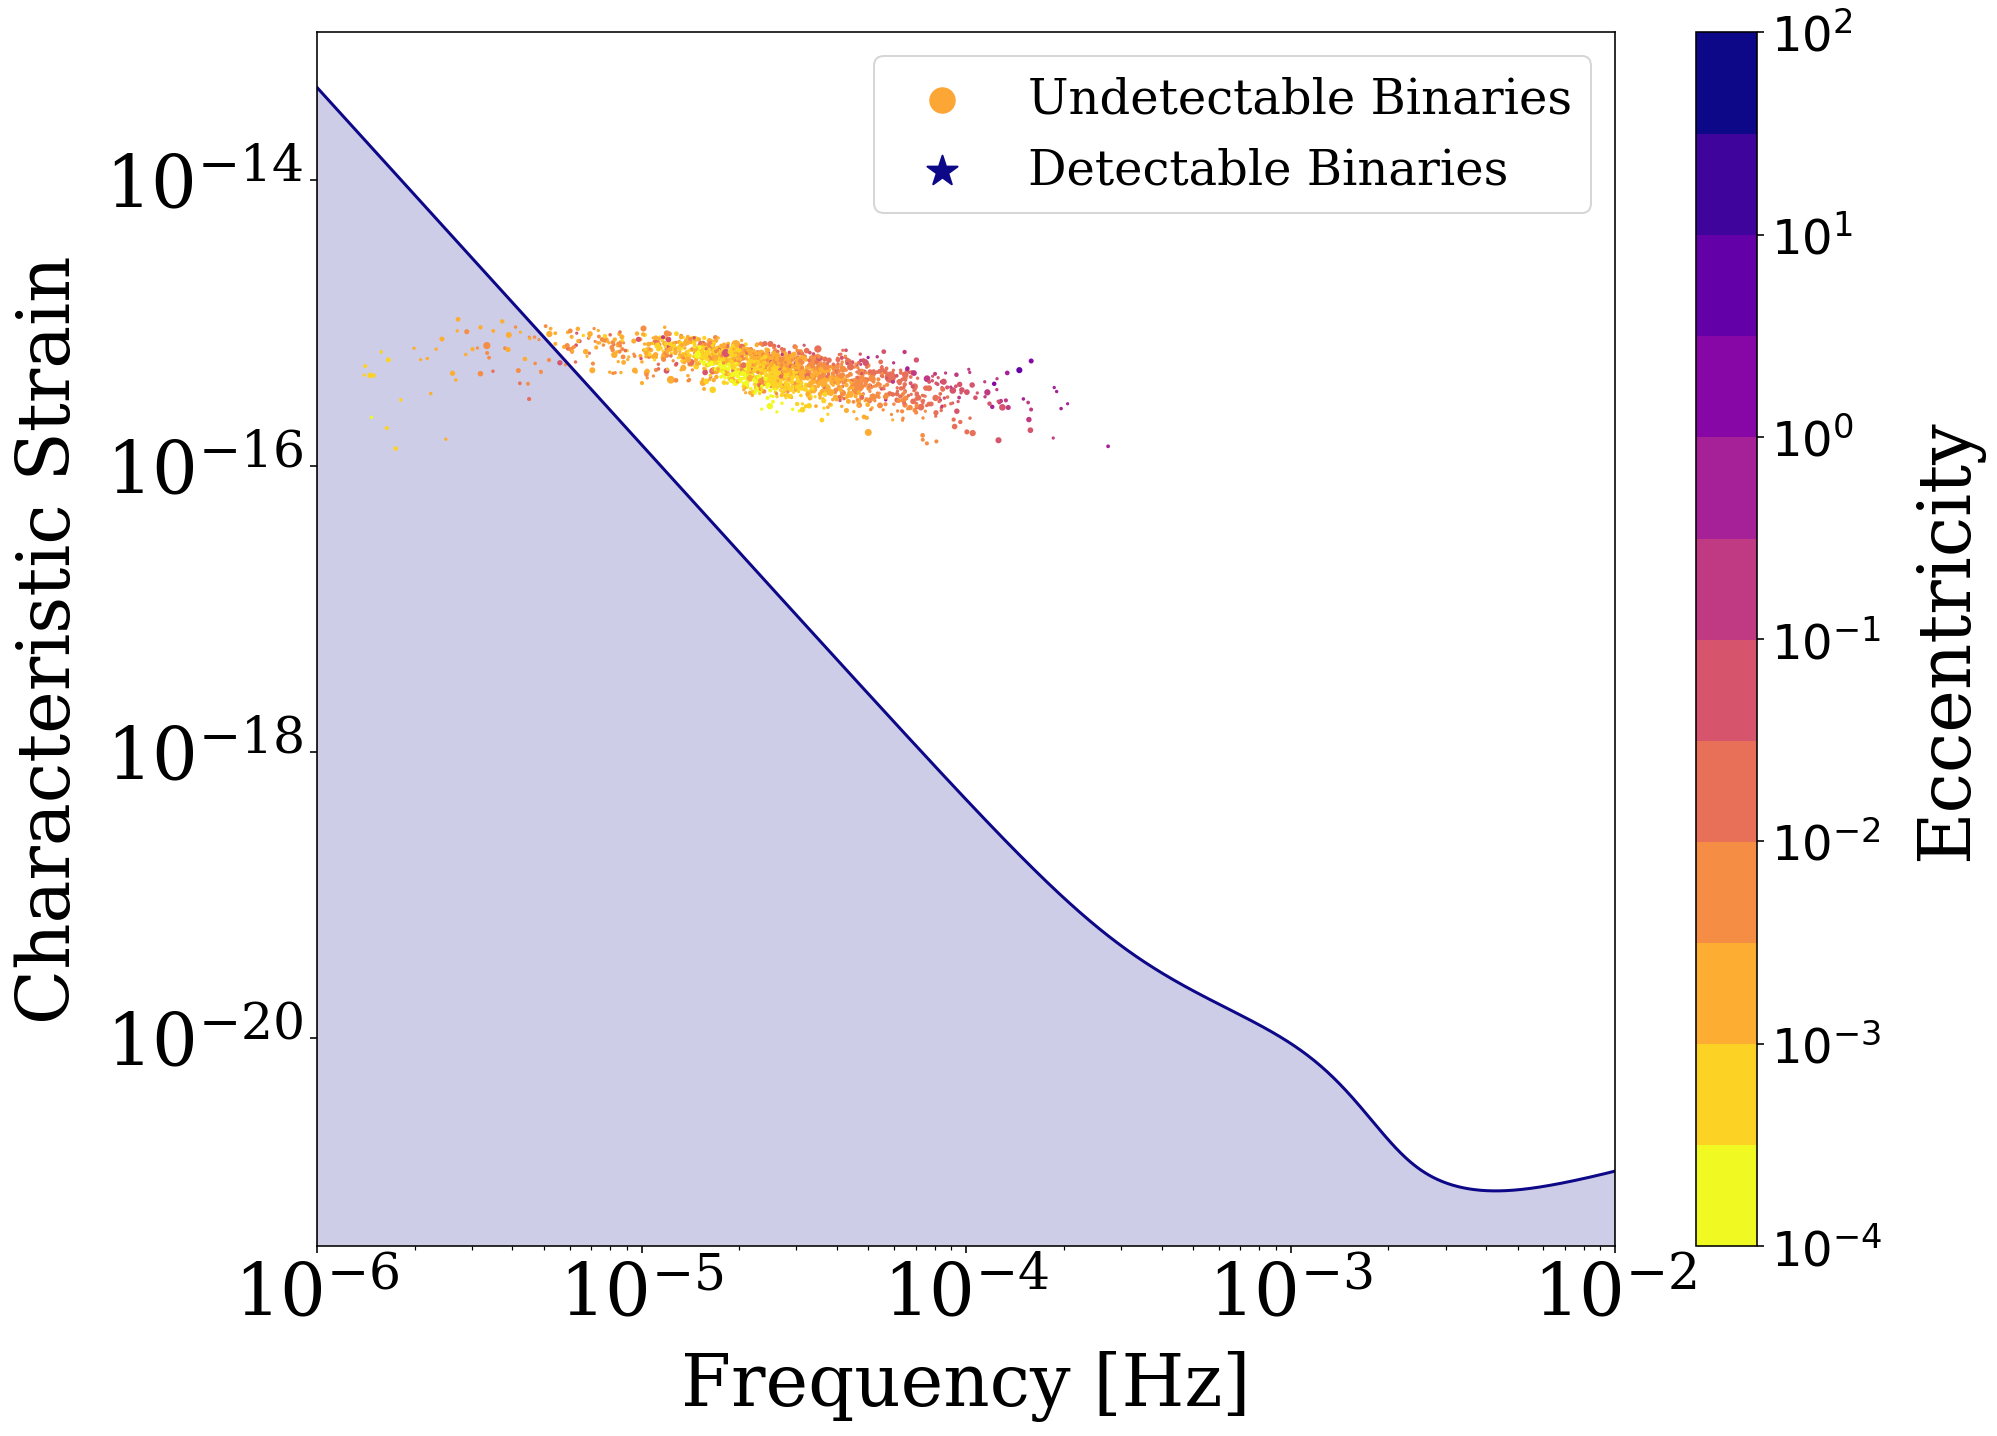

In [223]:
lisa = li.LISA()
plot_sensitivity_with_binaries(lisa.Sn, cstrain, snr, freq_currents, "Eccentricity", hide_binaries=False)#, "LISA_sensitivity_with_binaries_4years.png")
# plot_sensitivity_with_binaries(lisa.Sn, cstrain * np.power(freq_currents, -1/2), snr, freq_currents, "Eccentricity", asd=True, hide_binaries=False)#, "LISA_sensitivity_with_binaries_4years.png")
# plot_sensitivity_with_binaries(lisa.Sn, cstrain, long_snr, freq_currents, "Eccentricity: 10 Year Mission", e_currents, hide_binaries=False)#, "LISA_sensitivity_with_binaries_10years.png")
# plot_sensitivity_with_binaries(muAres.Sn_ares_full, cstrain, muAres_snr, freq_currents, r"Eccentricity: $\mu$-Ares", e_currents, hide_binaries=False)#, "muAres_sensitivity_with_binaries.png")

### 3. Run simulation 25,000 times to get a rate

In [ ]:
# run the simulation with LOOPS number of trials
LOOPS = 1000
st = time.time()
TOTAL_BINARIES = len(cm)

# for each store the number that are detectable
count_list = np.zeros(LOOPS)
weight_list = np.zeros(LOOPS)
detectable_binaries = np.zeros(LOOPS * 20, dtype=[
    ("weight", 'f4'), ('mass', 'f4'), ('separation', 'f4'), ('birth', 'f4'), ('frequency', 'f4'), 
    ('snr', 'f4'), ('m1', 'f4'), ('m2', 'f4'), ('distance', 'f4'), ('tform', 'f4'), ('a_init', 'f4'), ('tc', 'f4')
])
detections = 0
for i in range(LOOPS):
    # create random list of start times
    starts = np.random.rand(TOTAL_BINARIES)
    
    # double compact object starts after formation time
    dco_starts = starts * MW_AGE + tform
    
    # binary will evolve for the rest of the age of the milky way
    evolution_times = MW_AGE - dco_starts
    
    # find current separation and mask those that have already merged
    a_currents = evolve_a_circ(a, m1, m2, evolution_times)
    still_merging = np.isfinite(a_currents)
    
    # mask many arrays
    a_currents = a_currents[still_merging]
    weights = weightsDCO[still_merging]
    masses = cm[still_merging]
    times = tform[still_merging]
    births = dco_starts[still_merging]
    mass1, mass2 = m1[still_merging], m2[still_merging]
    a_init = a[still_merging]
    tco = tc[still_merging]
    
    # assume all binaries are at same angle and find distance from earth
    TOTAL_REMAINING = len(a_currents)
    radii = random_mw_distance(TOTAL_REMAINING)
    angles = 2 * np.pi * np.random.rand(TOTAL_REMAINING)
    heights = random_mw_distance(TOTAL_REMAINING, 0.3 * u.kpc) * np.random.choice([-1, 1], TOTAL_REMAINING)
    distances = np.sqrt(np.square(heights) + np.square(radii) + np.square(EARTH_TO_MW_CENTRE) - 2 * radii * EARTH_TO_MW_CENTRE * np.cos(angles))
    
    # convert separation to frequency and use this to find the snr
    freq_final = gw_frequency(a_currents, mass1, mass2)
    snr = calc_snr(cm[still_merging], distances, freq_final, lisa.Sn, 4 * u.yr)
    
    # store counts and weights
    count_list[i] = len(snr[snr > SNR_CUTOFF])
    weight_list[i] = np.sum(weights[snr > SNR_CUTOFF])
    
    # store other parameters
    for i in range(len(snr[snr > SNR_CUTOFF])):
        detectable_binaries[detections] = (
            weights[snr > SNR_CUTOFF][i], masses[snr > SNR_CUTOFF][i].value, a_currents[snr > SNR_CUTOFF][i].value,
            births[snr > SNR_CUTOFF][i].value, freq_final[snr > SNR_CUTOFF][i].value, snr[snr > SNR_CUTOFF][i].value,
            mass1[snr > SNR_CUTOFF][i].value, mass2[snr > SNR_CUTOFF][i].value, distances[snr > SNR_CUTOFF][i].value,
            times[snr > SNR_CUTOFF][i].value, a_init[snr > SNR_CUTOFF][i].value, tco[snr > SNR_CUTOFF][i].value
        )
        detections += 1

print("Calculations of {0} loops took {1}".format(LOOPS, time.time() - st))

In [ ]:
# get overall number of BHNS given weights
weighted_mergers = weight_list

# given we don't occupy full parameter space we correct using factor and mass we must correct
factor, MsunPerZ = TMEPZ.totalMassEvolvedPerZ(pathCOMPASh5=folder_path, Mlower=5, Mupper=150,  MminM2=0.1, binaryFraction=0.7, x4=200, Mmax=200)
if len(MsunPerZ) == 1:
    MsunPerZ = MsunPerZ[0]

# rate of mergers found by dividing
mergers_per_Msun = weighted_mergers / factor / MsunPerZ

# use mass of milky way to convert rate into 
MW_mass = 6e10
mergers_in_MW = mergers_per_Msun * MW_mass
ci = stats.t.interval(0.90, len(mergers_in_MW)-1, loc=np.mean(mergers_in_MW), scale=stats.sem(mergers_in_MW))
print("LISA Detection Rate --- Mean:{0:1.2f}".format(mergers_in_MW.mean()))
print("Confidence Interval:", ci)

In [ ]:
sns.set_palette("colorblind")

In [ ]:
# np.save("mergers_muares", mergers_in_MW)
# mergers_in_MW = np.load("mergers_muares.npy")

In [ ]:
lb, ub = np.round(np.percentile(mergers_in_MW, [5, 95]))
lb, ub = int(lb), int(ub)

In [ ]:
at_least_one = len(mergers_in_MW[mergers_in_MW >= 1])/len(mergers_in_MW)
print("Probability that there is at least 1 detection is {0:2.0f}%".format(at_least_one * 100))

In [ ]:
f = plt.figure(figsize=(10, 10))

bins = np.linspace(0, 20, 21)

matplotlib.rcParams['hatch.color'] = (1, 1, 1, 0.5)

hist, _, patches = plt.hist(mergers_in_MW, bins=bins, density=True)
for i in range(lb, ub):
    patches[i].set_hatch("/")

color90 = 'white'
median = np.percentile(mergers_in_MW, 50)
plt.plot([lb, lb], [0, hist[lb]], linewidth=2, color=color90, linestyle="--", alpha=0.5)
plt.plot([median, median], [0, hist[int(np.floor(median))]], linewidth=3, linestyle="--", color=color90)
plt.plot([ub, ub], [0, hist[ub - 1]], linewidth=2, color=color90, linestyle="--", alpha=0.5)

plt.annotate("Median: {0:1.2f} binaries".format(median), xy=(0.95, 0.95), xycoords='axes fraction', ha='right', fontsize=0.85*fs)
plt.annotate("90% Confidence: {0:1.1f}-{1:1.1f} binaries".format(np.percentile(mergers_in_MW, 5), np.percentile(mergers_in_MW, 95)), xy=(0.95, 0.90), xycoords='axes fraction', ha='right', fontsize=0.85*fs)
plt.xlabel("Number of Detectable Binaries", fontsize=fs)
plt.ylabel("Probability Density", fontsize=fs)
plt.tick_params(labelsize=0.7*fs)
plt.grid(True, axis="y")
plt.yscale("log")
plt.show()

# f.savefig("number_detectable.pdf", format="pdf", bbox_inches='tight')
# f.savefig("number_detectable_muares.png", bbox_inches='tight')

In [ ]:
# remove ending zeroes in array
detectable_binaries = detectable_binaries[:detections]

In [ ]:
def obtainM1BHandM2BHassymetric(m1, m2):
    m1bh, m2bh = np.zeros_like(m1), np.zeros_like(m1)
    maskm1heavier = (m1 >= m2)
    maskm2heavier = (m1 < m2)
    print(len(maskm2heavier[maskm2heavier]))
    m1bh[maskm1heavier] = m1[maskm1heavier]
    m1bh[maskm2heavier] = m2[maskm2heavier]
    m2bh[maskm1heavier] = m2[maskm1heavier]
    m2bh[maskm2heavier] = m1[maskm2heavier]
    return m1bh, m2bh # m1bh has all the heaviest systems

## 4. KDE Plots
### Helper Functions

In [ ]:
from scipy.spatial.distance import cdist

class gaussian_kde(object):
    def __init__(self, dataset, bw_method=None, weights=None):
        self.dataset = np.atleast_2d(dataset)
        if not self.dataset.size > 1:
            raise ValueError("`dataset` input should have multiple elements.")
        self.d, self.n = self.dataset.shape
            
        if weights is not None:
            self.weights = weights / np.sum(weights)
        else:
            self.weights = np.ones(self.n) / self.n
            
        # Compute the effective sample size 
        # http://surveyanalysis.org/wiki/Design_Effects_and_Effective_Sample_Size#Kish.27s_approximate_formula_for_computing_effective_sample_size
        self.neff = 1.0 / np.sum(self.weights ** 2)

        self.set_bandwidth(bw_method=bw_method)

    def evaluate(self, points):
        points = np.atleast_2d(points)

        d, m = points.shape
        if d != self.d:
            if d == 1 and m == self.d:
                # points was passed in as a row vector
                points = np.reshape(points, (self.d, 1))
                m = 1
            else:
                msg = "points have dimension %s, dataset has dimension %s" % (d,
                    self.d)
                raise ValueError(msg)

        # compute the normalised residuals
        chi2 = cdist(points.T, self.dataset.T, 'mahalanobis', VI=self.inv_cov) ** 2
        # compute the pdf
        result = np.sum(np.exp(-.5 * chi2) * self.weights, axis=1) / self._norm_factor

        return result

    __call__ = evaluate

    def scotts_factor(self):
        return np.power(self.neff, -1./(self.d+4))

    def silverman_factor(self):
        return np.power(self.neff*(self.d+2.0)/4.0, -1./(self.d+4))

    #  Default method to calculate bandwidth, can be overwritten by subclass
    covariance_factor = scotts_factor

    def set_bandwidth(self, bw_method=None):
        if bw_method is None:
            pass
        elif bw_method == 'scott':
            self.covariance_factor = self.scotts_factor
        elif bw_method == 'silverman':
            self.covariance_factor = self.silverman_factor
        elif np.isscalar(bw_method): # and not isinstance(bw_method, string_types):
            self._bw_method = 'use constant'
            self.covariance_factor = lambda: bw_method
        elif callable(bw_method):
            self._bw_method = bw_method
            self.covariance_factor = lambda: self._bw_method(self)
        else:
            msg = "`bw_method` should be 'scott', 'silverman', a scalar " \
                  "or a callable."
            raise ValueError(msg)

        self._compute_covariance()

    def _compute_covariance(self):
        """Computes the covariance matrix for each Gaussian kernel using
        covariance_factor().
        """
        self.factor = self.covariance_factor()
        # Cache covariance and inverse covariance of the data
        if not hasattr(self, '_data_inv_cov'):
            # Compute the mean and residuals
            _mean = np.sum(self.weights * self.dataset, axis=1)
            _residual = (self.dataset - _mean[:, None])
            # Compute the biased covariance
            self._data_covariance = np.atleast_2d(np.dot(_residual * self.weights, _residual.T))
            # Correct for bias (http://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Weighted_sample_covariance)
            self._data_covariance /= (1 - np.sum(self.weights ** 2))
            self._data_inv_cov = np.linalg.inv(self._data_covariance)

        self.covariance = self._data_covariance * self.factor**2
        self.inv_cov = self._data_inv_cov / self.factor**2
        self._norm_factor = np.sqrt(np.linalg.det(2*np.pi*self.covariance)) #* self.n
        
def lowess(x, y, f=2. / 3., iter=3):
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest

In [ ]:
def bootstrapkde(repeats, samples, weights, bins, bandwidths):
    """bootstraps the kde function to obtain 1- and 2-sigma 
    uncertainty intervals for the kde plotted in plotChirpmass_kde() """
    
    # make array where we will save each bootstrap result
    nbins = len(bins)
    array_probailities = np.zeros((repeats, nbins))
    
    xx_boot = bins
    weights /= np.sum(weights) # normalize weights        

    samples = np.asarray(samples)       
    boot_index = np.arange(len(samples))                                  
    for nr in range(repeats):
        # (bootstrap) re-sample a random set of samples with replacement from existing samples
        # do this by drawing random sample indecis nrs, each nr corresponds to a sample  
        boot_randindex = np.random.choice(boot_index, size=len(boot_index), replace=True, p=None)
        boot_randweight = np.asarray(weights)[boot_randindex] # get the corresponding weights 
        boot_randsamples = np.array(np.asarray(samples)[boot_randindex]) # get the corresponding samples
        
        # calculate the kde for this bootstrap 
        pdf_boot = gaussian_kde(boot_randsamples, weights=boot_randweight, bw_method = bandwidths)
        y_boot = pdf_boot(xx_boot)
        # add bootstrap kde to array
        array_probailities[nr,:] = y_boot
    
    # calculate the 1- and 2-sigma uncertainties from these bootstraps for below and above mean. 
    percentile_min1sigma = np.percentile(array_probailities, 15.89, axis=0)
    percentile_plus1sigma = np.percentile(array_probailities, 84.1, axis=0)
    percentile_min2sigma = np.percentile(array_probailities, 2.27, axis=0)
    percentile_plus2sigma = np.percentile(array_probailities, 97.725, axis=0)    
        
    std_bins = (np.std(array_probailities, axis=0)) 

    return [percentile_min1sigma, percentile_plus1sigma, percentile_min2sigma, percentile_plus2sigma]


def plot_kde(all_var, detect_var, xlab='', nbins=500, init_var=None, log=False, repeats=100, path=file_path, uncertainty=True, plot=False):
    # remove weights for artificial data
    weights = weightsDCOAll
    if len(all_var) != len(allBH):
        weights = np.ones(len(all_var))
    
    # settings for kde
    poissonErr = 4
    bandwidths = 0.095
    
    if log:
        all_var = np.log10(all_var)
        detect_var = np.log10(detect_var)
    
    min_val = min(min(all_var), min(detect_var))
    max_val = max(max(all_var), max(detect_var))
    
    if init_var is not None:
        if log:
            init_var = np.log10(init_var)
        min_val = min(min_val, min(init_var))
        max_val = max(max_val, max(init_var))
        
    print(min_val, max_val)
    
    bins = np.linspace(min_val, max_val, nbins)

    # calculate the kernel density estimator
    kde_all = gaussian_kde(all_var, weights=weights, bw_method=bandwidths)        
    yy_all = kde_all(bins)
    if init_var is not None:
        kde_init = gaussian_kde(init_var, weights=detectable_binaries["weight"], bw_method=bandwidths)        
        yy_init = kde_init(bins)
    kde_detectable = gaussian_kde(detect_var, weights=detectable_binaries["weight"], bw_method=bandwidths)        
    yy_detectable = kde_detectable(bins)

    # calculate uncertainties
    if uncertainty:
        percentiles_all = bootstrapkde(repeats=repeats, samples=all_var, weights=weights, bins=bins, bandwidths=bandwidths)
        if init_var is not None:
            percentiles_init = bootstrapkde(repeats=repeats, samples=init_var, weights=detectable_binaries["weight"], bins=bins, bandwidths=bandwidths)
        percentiles_detectable = bootstrapkde(repeats=repeats, samples=detect_var, weights=detectable_binaries["weight"], bins=bins, bandwidths=bandwidths)
    
    print("done!")
    
    if plot:
        d_col = '#3971bf'
        i_col = '#4a8f3c'
        f, axarr= plt.subplots(1, 1,  figsize=(10,10))
        axarr.plot(bins, yy_all, lw=3, color='grey', zorder=2003)
        axarr.plot(bins, yy_detectable, lw=3, color=d_col, zorder=2009)
        
        if uncertainty:
            axarr.fill_between(bins, percentiles_all[1], percentiles_all[0], \
                               alpha = 0.75, color ='grey', zorder = 2001)
            axarr.fill_between(bins, percentiles_all[3], percentiles_all[2], \
                               alpha = 0.45, color ='grey', zorder = 2000)
            axarr.fill_between(bins, percentiles_detectable[1], percentiles_detectable[0], \
                               alpha = 0.75, color=d_col, zorder = 2008)
            axarr.fill_between(bins, percentiles_detectable[3], percentiles_detectable[2], \
                               alpha = 0.45, color=d_col, zorder = 2007)
        if init_var:
            axarr.annotate(r"All Binaries - DCO Formation", xy=(0.036, 0.95), \
                              xycoords='axes fraction', fontsize=22, color='grey', weight='bold')
            axarr.annotate(r"Detectable Binaries - DCO Formation", xy=(0.036, 0.90), \
                              xycoords='axes fraction', fontsize=22, color=i_col, weight='bold')
            axarr.annotate(r"Detectable Binaries - During LISA", xy=(0.036, 0.85), \
                              xycoords='axes fraction', fontsize=22, color=d_col, weight='bold')
            axarr.plot(bins, yy_init, lw=3, color=i_col, zorder=2006)
            if uncertainty:
                axarr.fill_between(bins, percentiles_init[1], percentiles_init[0], \
                                   alpha = 0.75, color=i_col, zorder = 2005)
                axarr.fill_between(bins, percentiles_init[3], percentiles_init[2], \
                               alpha = 0.45, color=i_col, zorder = 2004)
        else:
            axarr.annotate(r"All Binaries", xy=(0.036, 0.95), \
                              xycoords='axes fraction', fontsize=22, color='grey', weight='bold')
            axarr.annotate(r"Detectable Binaries", xy=(0.036, 0.90), \
                              xycoords='axes fraction', fontsize=22, color=d_col, weight='bold')

        axarr.set_xlim(min(detect_var).value, max(all_var).value)

        if log:
            axarr.set_xscale("log")
            axarr.set_yscale("log")
            axarr.set_ylim((1e-2, 1e3))
            
        axarr.grid()
        axarr.tick_params(labelsize=24)
        
        axarr.set_xlabel(xlab, fontsize=30)
        axarr.set_ylabel('Probability Density', fontsize=30)

        plt.tight_layout(pad=0.4, w_pad=3, h_pad=3.0)
        plt.show()
        
        return
    elif uncertainty:
        if init_var is not None:
            return bins, yy_all, yy_detectable, yy_init, percentiles_all, percentiles_detectable, percentiles_init
        else:
            return bins, yy_all, yy_detectable, percentiles_all, percentiles_detectable
    else:
        if init_var is not None:
            return bins, yy_all, yy_detectable, yy_init
        else:
            return bins, yy_all, yy_detectable

In [ ]:
d_col='#3971bf'
i_col='#de8f05'

def plot_kde_on_axis(varname, axis, d_col='#3971bf', i_col='#de8f05', show=[True, True, True]):
    x, y, z = show
    
    if x:
        axis.plot(bins[varname], kde[varname], lw=3, color='grey', zorder=2003)
        axis.fill_between(bins[varname], un[varname][1], un[varname][0], alpha = 0.75, color ='grey', zorder = 2001)
        axis.fill_between(bins[varname], un[varname][3], un[varname][2], alpha = 0.45, color ='grey', zorder = 2000)
    
    if z:
        axis.plot(bins[varname], dkde[varname], lw=3, color=d_col, zorder=2009)
        axis.fill_between(bins[varname], dun[varname][1], dun[varname][0], alpha = 0.75, color=d_col, zorder = 2008)
        axis.fill_between(bins[varname], dun[varname][3], dun[varname][2], alpha = 0.45, color=d_col, zorder = 2007)
    
    if varname in set(['f', 'a']) and y:
        axis.plot(bins[varname], ikde[varname], lw=3, color=i_col, zorder=2006)
        axis.fill_between(bins[varname], iun[varname][1], iun[varname][0], alpha = 0.75, color=i_col, zorder = 2005)
        axis.fill_between(bins[varname], iun[varname][3], iun[varname][2], alpha = 0.45, color=i_col, zorder = 2004)
    
    axis.set_ylabel('Probability Density', fontsize=30)
    axis.grid()
    axis.tick_params(which='both', direction='in', length=10, width=2, labelsize=26)
    axis.tick_params(which='minor', length=5, width=1)
    return axis

def annotate_axes(axis, xloc='left', yloc='top', number=2, d_col='#3971bf', i_col='#de8f05', show=[True, True, True]):
    x = 0.03 if xloc == "left" else 0.97
    y = 0.95 if yloc == "top" else 0.05
    delta = -0.05 if yloc == "top" else 0.05
    
    a, b, c = show
    if number == 2:
        if a:
            axis.annotate(r"All Binaries", xy=(x, y), ha=xloc, xycoords='axes fraction', fontsize=26, color='grey', weight='bold')
        if b:
            axis.annotate(r"Detectable Binaries", xy=(x, y + delta), ha=xloc, xycoords='axes fraction', fontsize=26, color=d_col, weight='bold')
    else:
        if a:
            axis.annotate(r"All - DCO Formation", xy=(x, y), ha=xloc, xycoords='axes fraction', fontsize=26, color='grey', weight='bold')
        if b:
            axis.annotate(r"Detectable - DCO Formation", xy=(x, y + delta), ha=xloc, xycoords='axes fraction', fontsize=26, color=i_col, weight='bold')
        if c:
            axis.annotate(r"Detectable - During LISA", xy=(x, y + 2 * delta), ha=xloc, xycoords='axes fraction', fontsize=26, color=d_col, weight='bold')
    return axis

In [ ]:
# mask the data to get only BHNSs that merge in a Hubble time, have RLOF and are pessimistic
maskBHNS = maskTargetDCOsSTROOPWAFEL(DCOtype='BHNS', boolDCOmask=[0,1,1], f=fdata, otherSelection=None, otherparam=None)

allM1 = get_COMPAS_variable(['M1', 'doubleCompactObjects'], fdata)[maskBHNS] * u.M_sun
allM2 = get_COMPAS_variable(['M2', 'doubleCompactObjects'], fdata)[maskBHNS] * u.M_sun
allBH, allNS = obtainM1BHandM2BHassymetric(allM1, allM2)
allCM = chirp_mass(allBH, allNS)

alla = get_COMPAS_variable(['separationDCOFormation', 'doubleCompactObjects'], fdata)[maskBHNS] * u.au
allfreq = gw_frequency(alla, allBH, allNS)

alle = get_COMPAS_variable(['eccentricityDCOFormation', 'doubleCompactObjects'], fdata)[maskBHNS]

alltform = get_COMPAS_variable(['tform', 'doubleCompactObjects'], fdata)[maskBHNS] * u.Myr
alltc = get_COMPAS_variable(['tc', 'doubleCompactObjects'], fdata)[maskBHNS] * u.Myr

weightsDCOAll, weightsSystems = obtainweightsSTROOPWAFEL(fdata)
weightsDCOAll = weightsDCOAll[maskBHNS]

In [ ]:
repeats = 100
bins, kde, dkde, ikde, un, dun, iun = {}, {}, {}, {}, {}, {}, {}

In [ ]:
bins['m1'], kde['m1'], dkde['m1'], un['m1'], dun['m1'] = plot_kde(repeats=repeats, all_var=allBH.value, detect_var=detectable_binaries['m1'])

In [ ]:
f, axarr= plt.subplots(1, 1, figsize=(10,10))

axarr = plot_kde_on_axis('m1', axarr)
axarr = annotate_axes(axarr)

axarr.set_xlim(min(allBH).value, 13)

axarr.set_xlabel(r"$m_{\rm BH}\, [{\rm M_{\odot}}]$", fontsize=30)

plt.savefig("kde_mbh.pdf", format="pdf", bbox_inches="tight")
plt.savefig("kde_mbh.png", bbox_inches="tight")
plt.show()

In [ ]:
bins['m2'], kde['m2'], dkde['m2'], un['m2'], dun['m2'] = plot_kde(repeats=repeats, all_var=allNS.value, detect_var=detectable_binaries['m2'])

In [ ]:
f, axarr= plt.subplots(1, 1, figsize=(10,10))

axarr = plot_kde_on_axis('m2', axarr)
axarr = annotate_axes(axarr, xloc='right')

axarr.set_xlim(min(allNS).value, max(allNS).value)

axarr.set_xlabel(r"$m_{\rm NS}\, [{\rm M_{\odot}}]$", fontsize=30)

plt.savefig("kde_mns.pdf", format="pdf", bbox_inches="tight")
plt.savefig("kde_mns.png", bbox_inches="tight")
plt.show()

In [ ]:
bins['cm'], kde['cm'], dkde['cm'], un['cm'], dun['cm'] = plot_kde(repeats=repeats, all_var=allCM.value, detect_var=detectable_binaries['mass'])

In [ ]:
f, axarr= plt.subplots(1, 1, figsize=(10,10))

axarr = plot_kde_on_axis('cm', axarr)
axarr = annotate_axes(axarr, yloc='bottom')

axarr.set_xlim(min(allCM).value, max(allCM).value)

axarr.set_xlabel(r"$\mathcal{M}_{\rm c}\, [{\rm M_{\odot}}]$", fontsize=30)
plt.savefig("kde_mchirp.pdf", format="pdf", bbox_inches="tight")
plt.savefig("kde_mchirp.png", bbox_inches="tight")
plt.show()

In [ ]:
bins['a'], kde['a'], dkde['a'], ikde['a'], un['a'], dun['a'], iun['a'] = plot_kde(repeats=repeats, all_var=alla.value, detect_var=(detectable_binaries["separation"] * u.m).to(u.AU).value, init_var=detectable_binaries["a_init"], log=True)

In [ ]:
f, axarr= plt.subplots(1, 1,  figsize=(10,10))

axarr = plot_kde_on_axis('a', axarr)
axarr = annotate_axes(axarr, number=3)

axarr.set_xlim((-3, 0.7))

axarr.set_yscale("log")
axarr.set_ylim((1e-1, 1e1))

axarr.set_xlabel(r"$\log\, \rm{a}\, [{\rm AU}]$", fontsize=30)
plt.savefig("kde_a.pdf", format="pdf", bbox_inches="tight")
plt.savefig("kde_a.png", bbox_inches="tight")
plt.show()

In [ ]:
bins['f'], kde['f'], dkde['f'], ikde['f'], un['f'], dun['f'], iun['f'] = plot_kde(repeats=repeats, nbins=100, all_var=allfreq.value, detect_var=detectable_binaries["frequency"], init_var=gw_frequency(detectable_binaries["a_init"]*u.AU, detectable_binaries["m1"]*u.M_sun, detectable_binaries["m2"]*u.M_sun).value, log=True)

In [ ]:
f, axarr= plt.subplots(1, 1,  figsize=(10,10))
 
axarr = plot_kde_on_axis('f', axarr, show=[False, False, False])
axarr = annotate_axes(axarr, number=3, show=[False, False, False])

# axarr.axvspan(-4, -2, color=d_col, alpha=0.2)

axarr.set_xlim(-8, -2)

axarr.set_yscale("log")
axarr.set_ylim((1e-2, 1e1))

axarr.set_xlabel(r"$\log\, \rm{f}\,\, [{\rm Hz}]$", fontsize=30)
plt.savefig("kde_f_blank.png", bbox_inches="tight")
plt.show()

In [ ]:
f, axarr= plt.subplots(1, 1,  figsize=(10,10))
 
axarr = plot_kde_on_axis('f', axarr, show=[False, False, False])
axarr = annotate_axes(axarr, number=3, show=[False, False, False])

axarr.axvspan(-4, -2, color=d_col, alpha=0.2)

axarr.set_xlim(-8, -2)

axarr.set_yscale("log")
axarr.set_ylim((1e-2, 1e1))

axarr.set_xlabel(r"$\log\, \rm{f}\,\, [{\rm Hz}]$", fontsize=30)
plt.savefig("kde_f_area.png", bbox_inches="tight")
plt.show()

In [ ]:
f, axarr= plt.subplots(1, 1,  figsize=(10,10))
 
axarr = plot_kde_on_axis('f', axarr, show=[True, False, False])
axarr = annotate_axes(axarr, number=3, show=[True, False, False])

axarr.axvspan(-4, -2, color=d_col, alpha=0.2)

axarr.set_xlim(-8, -2)

axarr.set_yscale("log")
axarr.set_ylim((1e-2, 1e1))

axarr.set_xlabel(r"$\log\, \rm{f}\,\, [{\rm Hz}]$", fontsize=30)
plt.savefig("kde_f_all.png", bbox_inches="tight")
plt.show()

In [ ]:
f, axarr= plt.subplots(1, 1,  figsize=(10,10))
 
axarr = plot_kde_on_axis('f', axarr, show=[True, True, False])
axarr = annotate_axes(axarr, number=3, show=[True, True, False])

axarr.axvspan(-4, -2, color=d_col, alpha=0.2)

axarr.set_xlim(-8, -2)

axarr.set_yscale("log")
axarr.set_ylim((1e-2, 1e1))

axarr.set_xlabel(r"$\log\, \rm{f}\,\, [{\rm Hz}]$", fontsize=30)
plt.savefig("kde_f_atDCO.png", bbox_inches="tight")
plt.show()

In [ ]:
f, axarr= plt.subplots(1, 1,  figsize=(10,10))
 
axarr = plot_kde_on_axis('f', axarr)
axarr = annotate_axes(axarr, number=3)

axarr.axvspan(-4, -2, color=d_col, alpha=0.2)

axarr.set_xlim(-8, -2)

axarr.set_yscale("log")
axarr.set_ylim((1e-2, 1e1))

axarr.set_xlabel(r"$\log\, \rm{f}\,\, [{\rm Hz}]$", fontsize=30)
plt.savefig("kde_f.png", bbox_inches="tight")
plt.show()

In [ ]:
random_r = random_mw_distance(len(allCM))
angles = 2 * np.pi * np.random.rand(len(allCM))
random_d = np.sqrt(np.square(random_r) + np.square(EARTH_TO_MW_CENTRE) - 2 * random_r * EARTH_TO_MW_CENTRE * np.cos(angles))

In [ ]:
bins['d'], kde['d'], dkde['d'], un['d'], dun['d'] = plot_kde(repeats=repeats, nbins=100, all_var=random_d.value, detect_var=detectable_binaries["distance"], log=True)

In [ ]:
f, axarr= plt.subplots(1, 1,  figsize=(10,10))

axarr = plot_kde_on_axis('d', axarr)
axarr = annotate_axes(axarr)

axarr.set_xlim((min(np.log10(random_d.value)), max(np.log10(random_d.value))))
# axarr.set_ylim((1e-4, 1e1))
# axarr.set_yscale("log")

axarr.set_xlabel(r"$\log \, \rm{d}\, [{\rm kpc}]$", fontsize=30)
plt.savefig("kde_d.pdf", format="pdf", bbox_inches="tight")
plt.savefig("kde_d.png", bbox_inches="tight")
plt.show()

In [ ]:
bins['tf'], kde['tf'], dkde['tf'], un['tf'], dun['tf'] = plot_kde(repeats=repeats, all_var=alltform.to(u.Myr).value, detect_var=detectable_binaries["tform"] / 1e6)

In [ ]:
f, axarr= plt.subplots(1, 1,  figsize=(10,10))

axarr = plot_kde_on_axis('tf', axarr)
axarr = annotate_axes(axarr, xloc='right')

axarr.set_xlim(min(alltform).to(u.Myr).value, max(alltform).to(u.Myr).value)

axarr.set_xlabel(r"$t_{\rm form}\, [{\rm Myr}]$", fontsize=30)
plt.savefig("kde_tform.pdf", format="pdf", bbox_inches="tight")
plt.savefig("kde_tform.png", bbox_inches="tight")
plt.show()

In [ ]:
uniform = np.random.rand(len(allBH)) * MW_AGE

In [ ]:
bins['td'], kde['td'], dkde['td'], un['td'], dun['td'] = plot_kde(repeats=repeats, all_var=uniform.to(u.Gyr).value, detect_var=(detectable_binaries["birth"] * u.yr).to(u.Gyr).value)

In [ ]:
f, axarr= plt.subplots(1, 1,  figsize=(10,10))

axarr = plot_kde_on_axis('td', axarr, show=[False, False, False])
axarr = annotate_axes(axarr, show=[False, False, False])

axarr.set_xlim(0, 10)
axarr.set_ylim(0, 0.25)

axarr.set_xlabel(r"$t_{\rm DCO}\, [{\rm Gyr}]$", fontsize=30)
plt.savefig("kde_tdco_blank.png", bbox_inches="tight")
plt.show()

In [ ]:
f, axarr= plt.subplots(1, 1,  figsize=(10,10))

axarr = plot_kde_on_axis('td', axarr, show=[True, False, False])
axarr = annotate_axes(axarr, show=[True, False, False])

axarr.set_xlim(0, 10)
axarr.set_ylim(0, 0.25)

axarr.set_xlabel(r"$t_{\rm DCO}\, [{\rm Gyr}]$", fontsize=30)
plt.savefig("kde_tdco_all.png", bbox_inches="tight")
plt.show()

In [ ]:
f, axarr= plt.subplots(1, 1,  figsize=(10,10))

axarr = plot_kde_on_axis('td', axarr)
axarr = annotate_axes(axarr)

axarr.set_xlim(0, 10)
axarr.set_ylim(0, 0.25)

axarr.set_xlabel(r"$t_{\rm DCO}\, [{\rm Gyr}]$", fontsize=30)
# plt.savefig("kde_tdco.pdf", format="pdf", bbox_inches="tight")
plt.savefig("kde_tdco.png", bbox_inches="tight")
plt.show()

In [ ]:
bins['tc'], kde['tc'], dkde['tc'], un['tc'], dun['tc'] = plot_kde(repeats=repeats, all_var=tc.to(u.Gyr).value, detect_var=(detectable_binaries["tc"] * u.yr).to(u.Gyr).value)

In [ ]:
f, axarr= plt.subplots(1, 1,  figsize=(10,10))

axarr = plot_kde_on_axis('tc', axarr)
axarr = annotate_axes(axarr, xloc='right')

axarr.set_xlim(min(alltc).to(u.Gyr).value, 14)

axarr.set_yscale("log")
axarr.set_ylim((1e-3, 1e0))

axarr.set_xlabel(r"$t_{\rm c}\, [{\rm Gyr}]$", fontsize=30)
plt.savefig("kde_tc.pdf", format="pdf", bbox_inches="tight")
plt.savefig("kde_tc.png", bbox_inches="tight")
plt.show()

In [ ]:
f, axes = plt.subplots(3, 3,  figsize=(30,30))

## black hole mass ##
axes[0, 0] = plot_kde_on_axis('m1', axes[0, 0])
axes[0, 0] = annotate_axes(axes[0, 0])
axes[0, 0].set_xlim(min(allBH).value, 13)
axes[0, 0].set_xlabel(r"$m_{\rm BH}\, [{\rm M_{\odot}}]$", fontsize=30)

## neutron star mass ##
axes[0, 1] = plot_kde_on_axis('m2', axes[0, 1])
axes[0, 1] = annotate_axes(axes[0, 1], xloc='right')
axes[0, 1].set_xlim(min(allNS).value, max(allNS).value)
axes[0, 1].set_xlabel(r"$m_{\rm NS}\, [{\rm M_{\odot}}]$", fontsize=30)

## chirp mass ##
axes[0, 2] = plot_kde_on_axis('cm', axes[0, 2])
axes[0, 2] = annotate_axes(axes[0, 2], yloc='bottom')
axes[0, 2].set_xlim(min(allCM).value, 4.5)
axes[0, 2].set_xlabel(r"$\mathcal{M}_{\rm c}\, [{\rm M_{\odot}}]$", fontsize=30)

## frequency ##
axes[1, 0] = plot_kde_on_axis('f', axes[1, 0])
axes[1, 0] = annotate_axes(axes[1, 0], number=3)
axes[1, 0].axvspan(-4, -2, color=d_col, alpha=0.2)
axes[1, 0].set_xlim(-8, -2)
axes[1, 0].set_xlabel(r"$\log\, \rm{f}\,\, [{\rm Hz}]$", fontsize=30)
axes[1, 0].set_yscale("log")
axes[1, 0].set_ylim((1e-2, 1e1))

## separation ##
axes[1, 1] = plot_kde_on_axis('a', axes[1, 1])
axes[1, 1] = annotate_axes(axes[1, 1], number=3)
axes[1, 1].set_xlim((-3, 1))
axes[1, 1].set_xlabel(r"$\log\, \rm{a}\, [{\rm AU}]$", fontsize=30)
axes[1, 1].set_yscale("log")
axes[1, 1].set_ylim((1e-1, 1e1))

## distance ##
axes[1, 2] = plot_kde_on_axis('d', axes[1, 2])
axes[1, 2] = annotate_axes(axes[1, 2])
axes[1, 2].set_xlim(-0.5, max(np.log10(random_d.value)))
axes[1, 2].set_xlabel(r"$\log \, \rm{d}\, [{\rm kpc}]$", fontsize=30)

## tform ##
axes[2, 0] = plot_kde_on_axis('tf', axes[2, 0])
axes[2, 0] = annotate_axes(axes[2, 0], xloc='right')
axes[2, 0].set_xlim(min(alltform).to(u.Myr).value, max(alltform).to(u.Myr).value)
axes[2, 0].set_xlabel(r"$t_{\rm form}\, [{\rm Myr}]$", fontsize=30)

## tdco ##
axes[2, 1] = plot_kde_on_axis('td', axes[2, 1])
axes[2, 1] = annotate_axes(axes[2, 1])
axes[2, 1].set_xlim(min(uniform).to(u.Gyr).value, max(uniform).to(u.Gyr).value)
axes[2, 1].set_xlabel(r"$t_{\rm DCO}\, [{\rm Gyr}]$", fontsize=30)

## tc ##
axes[2, 2] = plot_kde_on_axis('tc', axes[2, 2])
axes[2, 2] = annotate_axes(axes[2, 2], xloc='right')
axes[2, 2].set_xlim(min(tc).to(u.Gyr).value, 14)
axes[2, 2].set_yscale("log")
axes[2, 2].set_ylim((1e-3, 1e0))
axes[2, 2].set_xlabel(r"$t_{\rm c}\, [{\rm Gyr}]$", fontsize=30)

plt.tight_layout(pad=0.4, w_pad=3, h_pad=3.0)
plt.savefig("all_params_grid_kde.pdf", format="pdf", bbox_inches="tight")
plt.savefig("all_params_grid_kde.png", bbox_inches="tight")
plt.show()

# Attempt at Eccentricity

In [135]:
def orbital_period(a, m1, m2):
    T = 2 * np.pi * np.sqrt(np.power(a, 3) / (c.G * (m1 + m2)))
    return T.to(u.day)

In [ ]:
print(orbital_period(a, m1, m2).to(u.s))
print(orbital_period(a, m1, m2).to(u.s) * gw_frequency(a, m1, m2).to(1 / u.s))

In [ ]:
f, ax = plt.subplots(1, figsize=(12, 10))

period = orbital_period(a, m1, m2)

plt.scatter(np.log10(period.value), e, s=10, label="At DCO", color="grey")

starts = np.random.rand(len(tc))

# double compact object starts after formation time
dco_starts = starts * MW_AGE + tform

# binary will evolve for the rest of the age of the milky way
evolution_times = MW_AGE - dco_starts

## PLOT LINE
# period_mask = np.logical_and(np.log10(period.value) > -1, np.log10(period.value) < -0.5)
# e_mask = np.logical_and(e > 0.68, e < 0.72)
# t_mask = tc.to(u.yr).value < evolution_times.to(u.yr).value
# traj = np.logical_and(np.logical_and(period_mask, e_mask), t_mask)
# ti = 0
# print(min(evolution_times[traj][ti].to(u.Myr), tc[traj][ti].to(u.Myr)))
# beta = (c.G**3 * m1[traj][ti] * m2[traj][ti] * (m1[traj][ti] + m2[traj][ti]) / c.c**5).to(u.m**4 / u.s).value
# sol = odeint(orbit_evolution, [a[traj][ti].to(u.m).value, e[traj][ti]],
#              np.linspace(0, (48 * u.Myr).to(u.s), 2000),
#             args=(beta,), tfirst=True)

# aline, eline = np.transpose(sol)
# print(aline)
# print(eline)
# pline = orbital_period(aline * u.m, m1[traj][ti].to(u.kg), m2[traj][ti].to(u.kg)).to(u.day)
# plt.plot(np.log10(pline.value), eline, lw=2, color='black', zorder=1000)

# period_mask = np.logical_and(np.log10(period.value) > 0.5, np.log10(period.value) < 1)
# t_mask = tc.to(u.yr).value < evolution_times.to(u.yr).value
# traj = np.logical_and(period_mask, t_mask)
# ti = 2
# print(min(evolution_times[traj][ti].to(u.Myr), tc[traj][ti].to(u.Myr)))
# beta = (c.G**3 * m1[traj][ti] * m2[traj][ti] * (m1[traj][ti] + m2[traj][ti]) / c.c**5).to(u.m**4 / u.s).value
# sol = odeint(orbit_evolution, [a[traj][ti].to(u.m).value, e[traj][ti]],
#              np.linspace(0, (evolution_times[traj][ti]).to(u.s), 2000),
#             args=(beta,), tfirst=True)

# aline, eline = np.transpose(sol)
# print(aline)
# print(eline)
# pline = orbital_period(aline * u.m, m1[traj][ti].to(u.kg), m2[traj][ti].to(u.kg)).to(u.day)
# plt.plot(np.log10(pline.value), eline, lw=2, color='black', zorder=1000)
## DONE PLOT LINE

# find current separation and mask those that have already merged
still_merging = evolution_times < tc

evolution_times = evolution_times[still_merging]
mass1, mass2 = m1[still_merging], m2[still_merging]
a_init = a[still_merging]
e_init = e[still_merging]

e_currents, c0 = evolve_eccentricity(e_init, a_init, mass1, mass2, evolution_times, 100)
a_currents = e_to_a(e_currents, c0)

plt.scatter(np.log10(orbital_period(a_currents, mass1, mass2).value),
            e_currents, s=10, label="Today", color="orange")

plt.xlabel(r"$\log_{10}$ Period [days]", fontsize=fs)
plt.ylabel("Eccentricity", fontsize=fs)

plt.annotate("BHNS at DCO", xy=(0.98, 0.11), ha='right', xycoords='axes fraction', fontsize=fs, color='grey')
plt.annotate("BHNS today", xy=(0.98, 0.06), ha='right', xycoords='axes fraction', fontsize=fs, color='orange')

ax.tick_params(which='both', labelsize=fs)

plt.xlim((-1.2, 3))

plt.grid(True)

plt.show()

In [ ]:
i = 6
print("{0}, {1}, {2}, {3}, {4}, {5}".format(a[i].value, e[i], m1[i].value, m2[i].value, tc[i].value, evolution_times[i].to(u.Myr).value))